In [1]:
import pandas as pd
import numpy as np
import SimpleITK as sitk
import os 

In [ ]:
import os
import numpy as np
import nibabel as nib
from glob import glob

## IN THIS CELL WE OBTAIN THE DIFFERENT PATHS FOR ALL THE DATA REQUIRED BY OUR MODEL
## ADAPT THIS TO GET MRI AS WELL AND A MASK 

def select_ctv_variant(structlist, base):
    """
    Select the most suitable variant for a given CTV base name (CTV_1, CTV_2, etc.)
    Priority: exact match > highest dose suffix > longest name
    """
    candidates = [s for s in structlist if s.startswith(base)]
    if not candidates:
        return None

    # Prioritize exact match
    exact = [s for s in candidates if s == f"{base}.nii.gz"]
    if exact:
        return exact[0]

    # Else sort by preferred suffix
    # Example scoring: 70 > 66 > rest
    def score(name):
        if '70' in name:
            return 3
        elif '66' in name:
            return 2
        elif any(c in name for c in ['A', 'B']):
            return 1
        return 0

    candidates.sort(key=score, reverse=True)
    return candidates[0] if candidates else None

StructureNames = ["Canal_medullaire", "Tronc", "Parotide_D", "Parotide_G",
                  "Oesophage", "Larynx", "Mandibule"]


pnbdict = {}

for pid in os.listdir('/.../data/'):
    try:
        base_path = f'/.../data/{pid}'
        rtstruct_path = os.path.join(base_path, 'RTStructS2')
        structlist = os.listdir(rtstruct_path)


        # Select proper CTVs
        ctv1 = select_ctv_variant(structlist, "CTV_1")
        ctv2 = select_ctv_variant(structlist, "CTV_2")
        ctv3 = select_ctv_variant(structlist, "CTV_3")

        if not all([ctv1, ctv2, ctv3]):
            continue  # skip patient

        # Paths to the selected masks
        ctv_paths = [os.path.join(rtstruct_path, ctv) for ctv in [ctv3, ctv2, ctv1]]

        # Other structures
        struct_list = [os.path.join(rtstruct_path, f'{s}.nii.gz') for s in StructureNames]
        check_struct = np.all([os.path.isfile(x) for x in struct_list])

        # Input files
        ct_synth = f'/datasynth/synthct_e0_{pid}.nii.gz'
        cbct = os.path.join(base_path, 'cbct0_deformed.nii.gz')
        ct = os.path.join(base_path, 'ct_deformed.nii.gz')
        dose = os.path.join(base_path, 'dose_aligned.nii.gz')
        mask = f'/.../{pid}/mask_s2.nii.gz'

        check_images =  np.all([os.path.isfile(x) for x in [ct_synth,cbct,ct,mask]])


        if check_struct and check_images :

            
            pnbdict[pid] = {
                'ct': ct,
                'cbct': cbct,
                'ct_synth': ct_synth,
                'dose': dose,
                'structure_masks': struct_list+ctv_paths,
                'possible_dose_mask':mask
            }

    except Exception as e:
        continue

In [ ]:
pnbdict


In [4]:
from monai.transforms import *

all_keys = ['ct','cbct','structure_masks','possible_dose_mask','ct_synth']
image_key = ['ct','cbct','ct_synth']
mask_keys = ['structure_masks','possible_dose_mask']

Transforms =  Compose([ LoadImaged(keys=all_keys),
            EnsureChannelFirstd(keys=all_keys),
            ResampleToMatchd(keys=['cbct','structure_masks','possible_dose_mask','ct_synth'],key_dst='ct'),
            ToTensord(keys=all_keys),
            OrientationD(keys=all_keys,axcodes='SPL'),
            ScaleIntensityRanged(keys=image_key, a_min=-1024, a_max=1500, b_min=-1.024, b_max=1.5, clip=True),
            Resized(keys=image_key,spatial_size=(128,128,128),mode='bilinear'),
            Resized(keys=mask_keys,spatial_size=(128,128,128),mode='nearest-exact'),
            EnsureTyped(keys=all_keys),
        ])

In [5]:
x_original = pnbdict['06278']
x = Transforms(x_original)

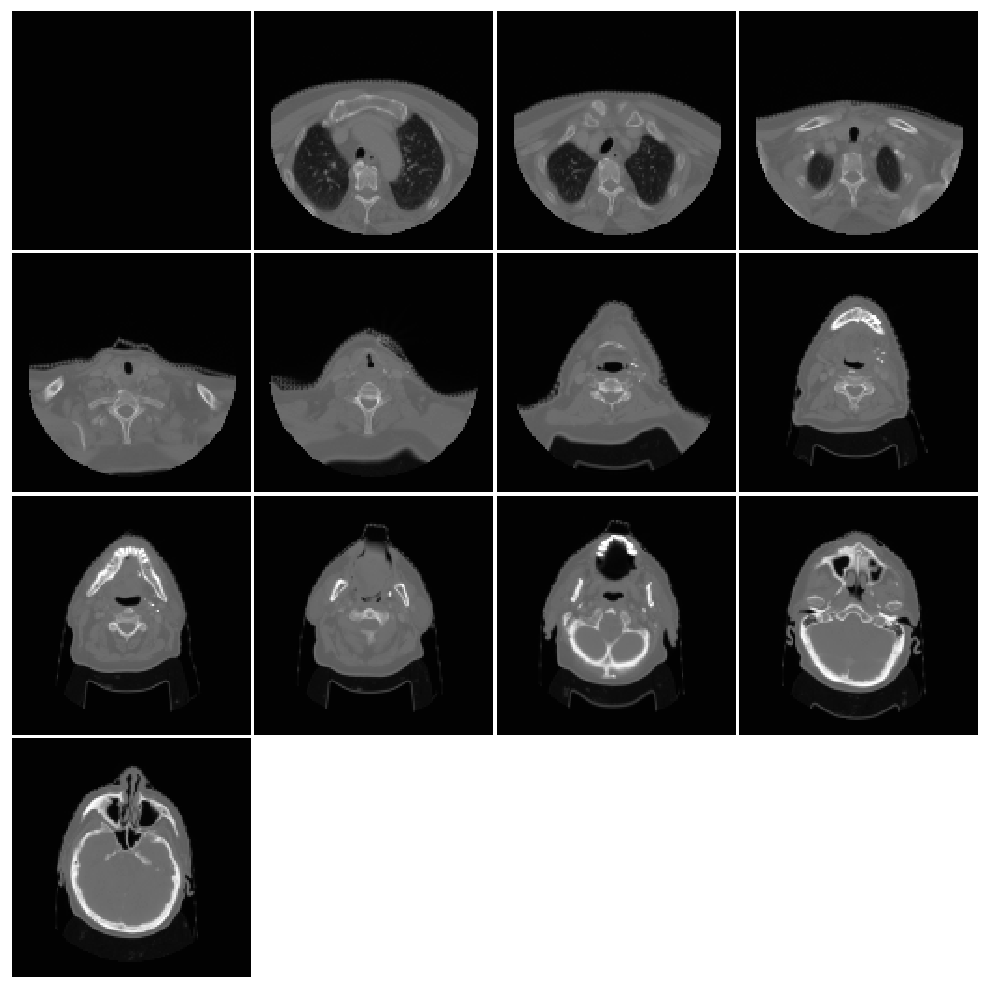

In [6]:
from monai.visualize import matshow3d

fig = matshow3d(x['ct'][0],cmap='gray',every_n=10)

In [ ]:
#Load Model
from Modules.model import *
weights = '/.../weight/epoch=399-step=40000.ckpt'
model = Dose_Prediction_Model.load_from_checkpoint(weights)
model = model.to('cuda')

BasicUNetPlusPlus features: (32, 64, 128, 256, 512, 32).


Infer

In [8]:
with torch.no_grad():
    model.eval()
    input = torch.cat((x['cbct'], x['structure_masks']), dim=0).unsqueeze(0).to('cuda')
    out = model.forward(input).to('cpu')
    outCBCT = out[0]*x['possible_dose_mask']
    

with torch.no_grad():
    model.eval()
    input = torch.cat((x['ct'], x['structure_masks']), dim=0).unsqueeze(0).to('cuda')
    out = model.forward(input).to('cpu')
    outCT = out[0]*x['possible_dose_mask']  


with torch.no_grad():
    model.eval()
    input = torch.cat((x['ct_synth'], x['structure_masks']), dim=0).unsqueeze(0).to('cuda')
    out = model.forward(input).to('cpu')
    outSCT = out[0]*x['possible_dose_mask']  

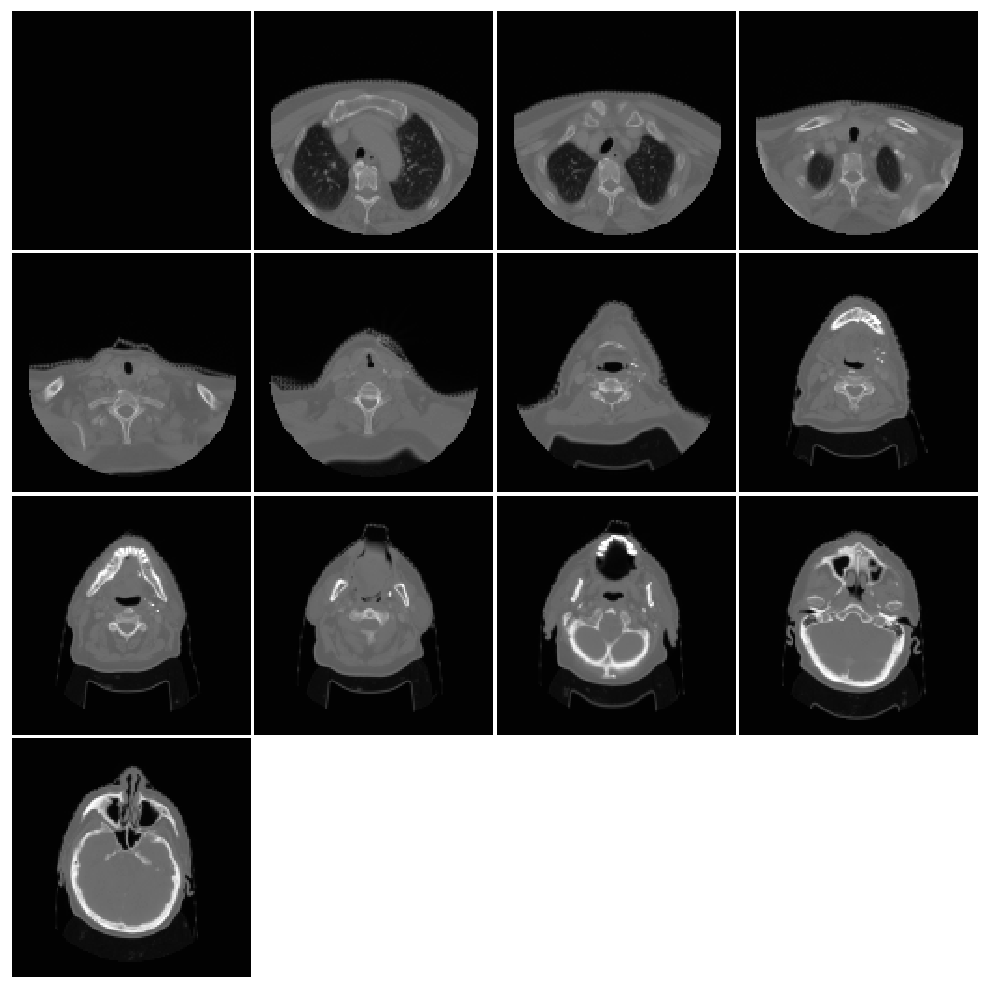

In [9]:
fig = matshow3d(x['ct'][0],cmap='gray',every_n=10)

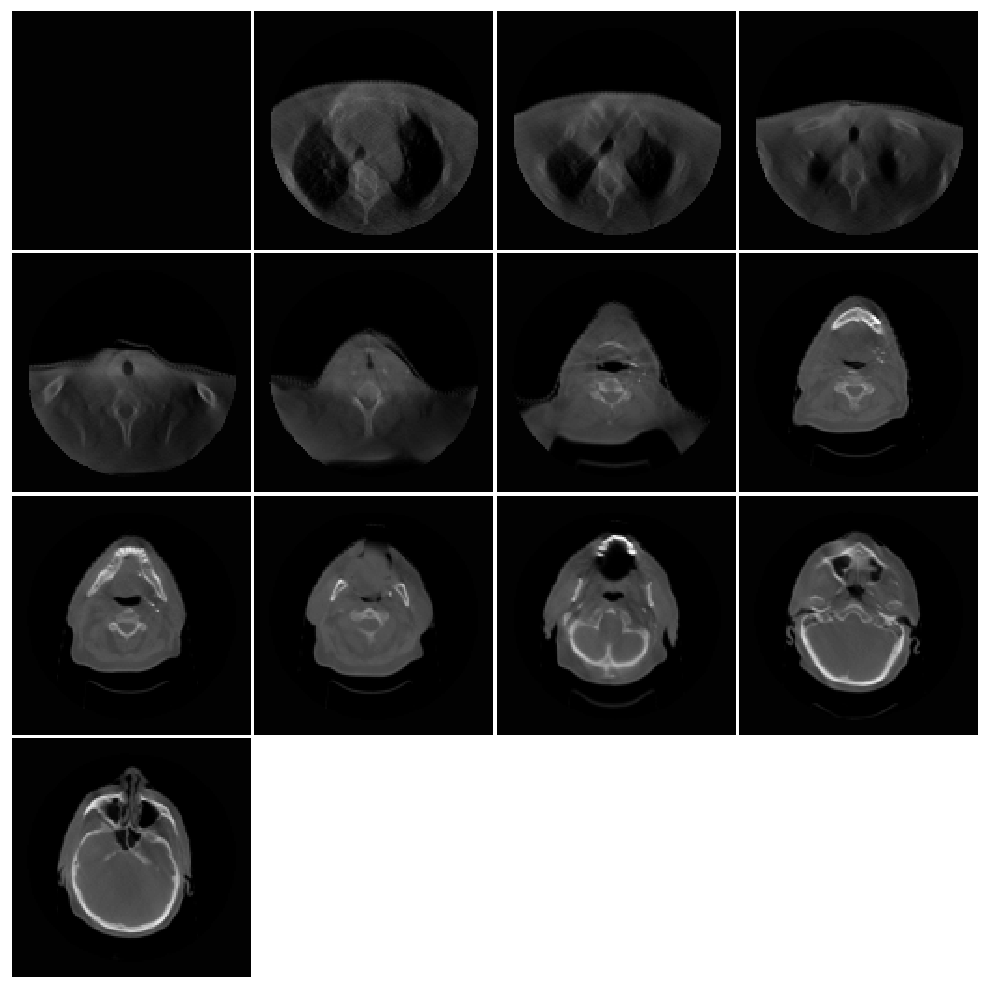

In [10]:
fig = matshow3d(x['cbct'][0],cmap='gray',every_n=10)

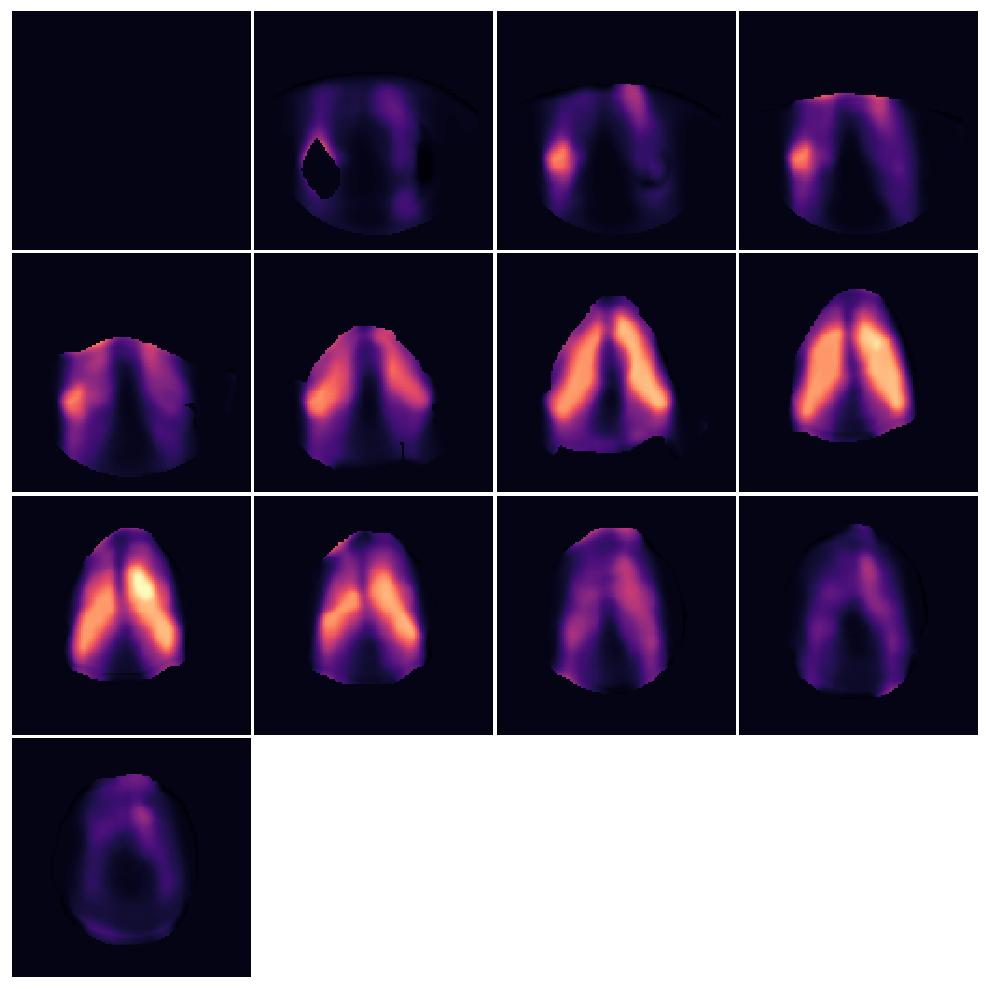

In [11]:
fig = matshow3d(outCBCT[0],cmap='magma',every_n=10)

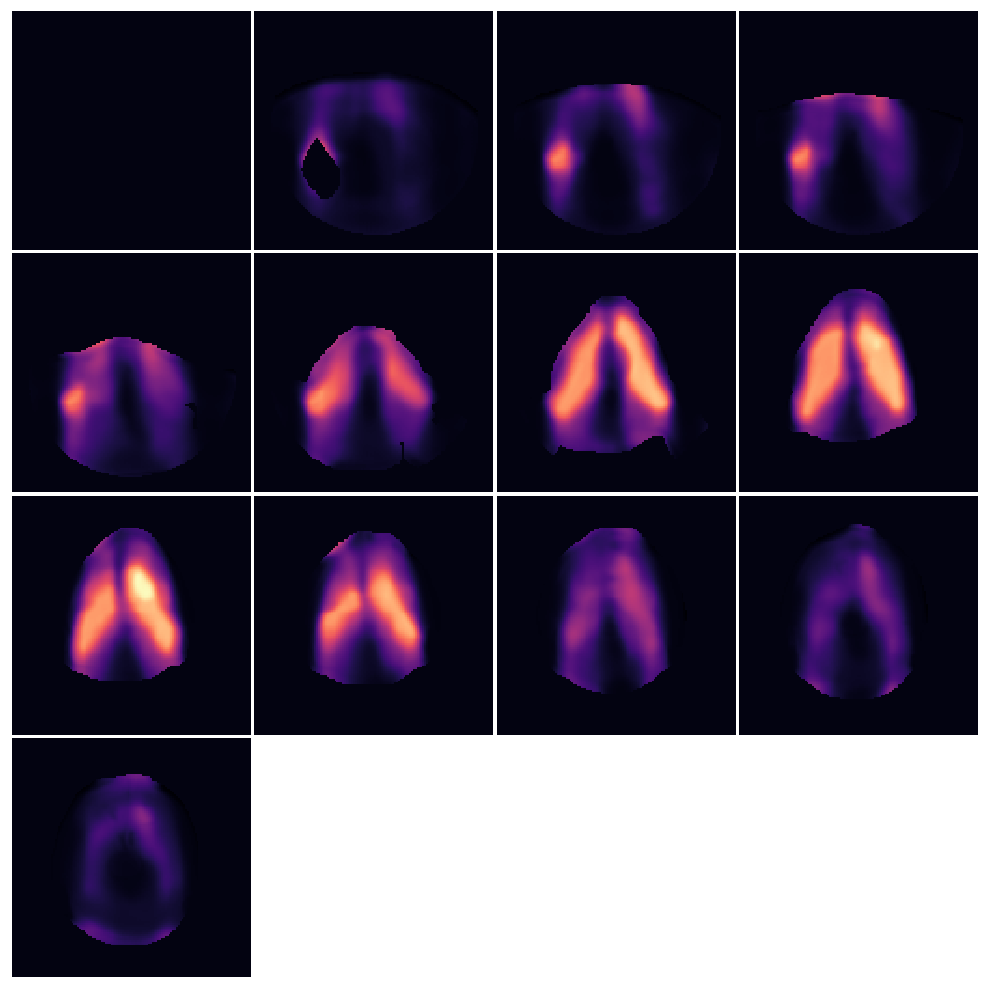

In [12]:
fig = matshow3d(outCT[0],cmap='magma',every_n=10)

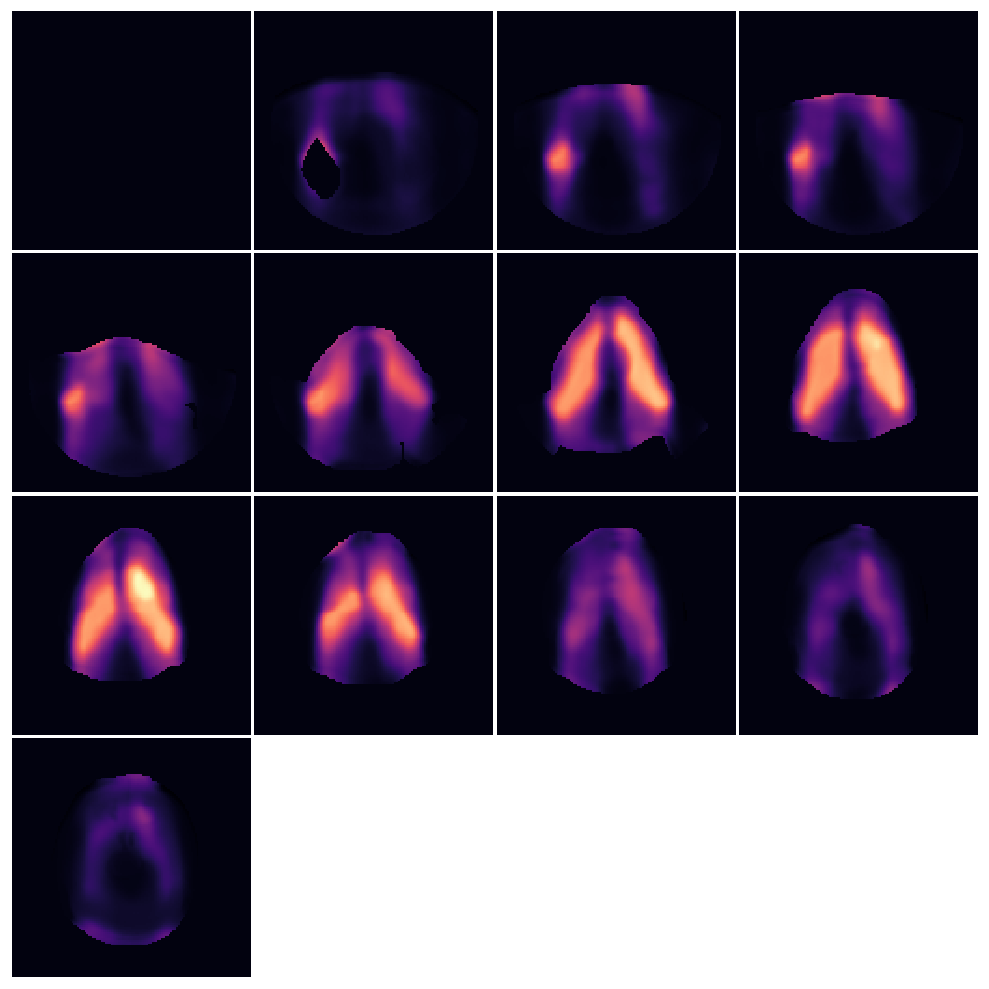

In [13]:
fig = matshow3d(outSCT[0],cmap='magma',every_n=10)

In [15]:
x_out = {'ct':x['ct'],'cbct':x['cbct'],'dose_ct':outCT,'dose_cbct':outCBCT,'structures':x['structure_masks'],'dose_sCT':outSCT,'sCT':x['ct_synth']}

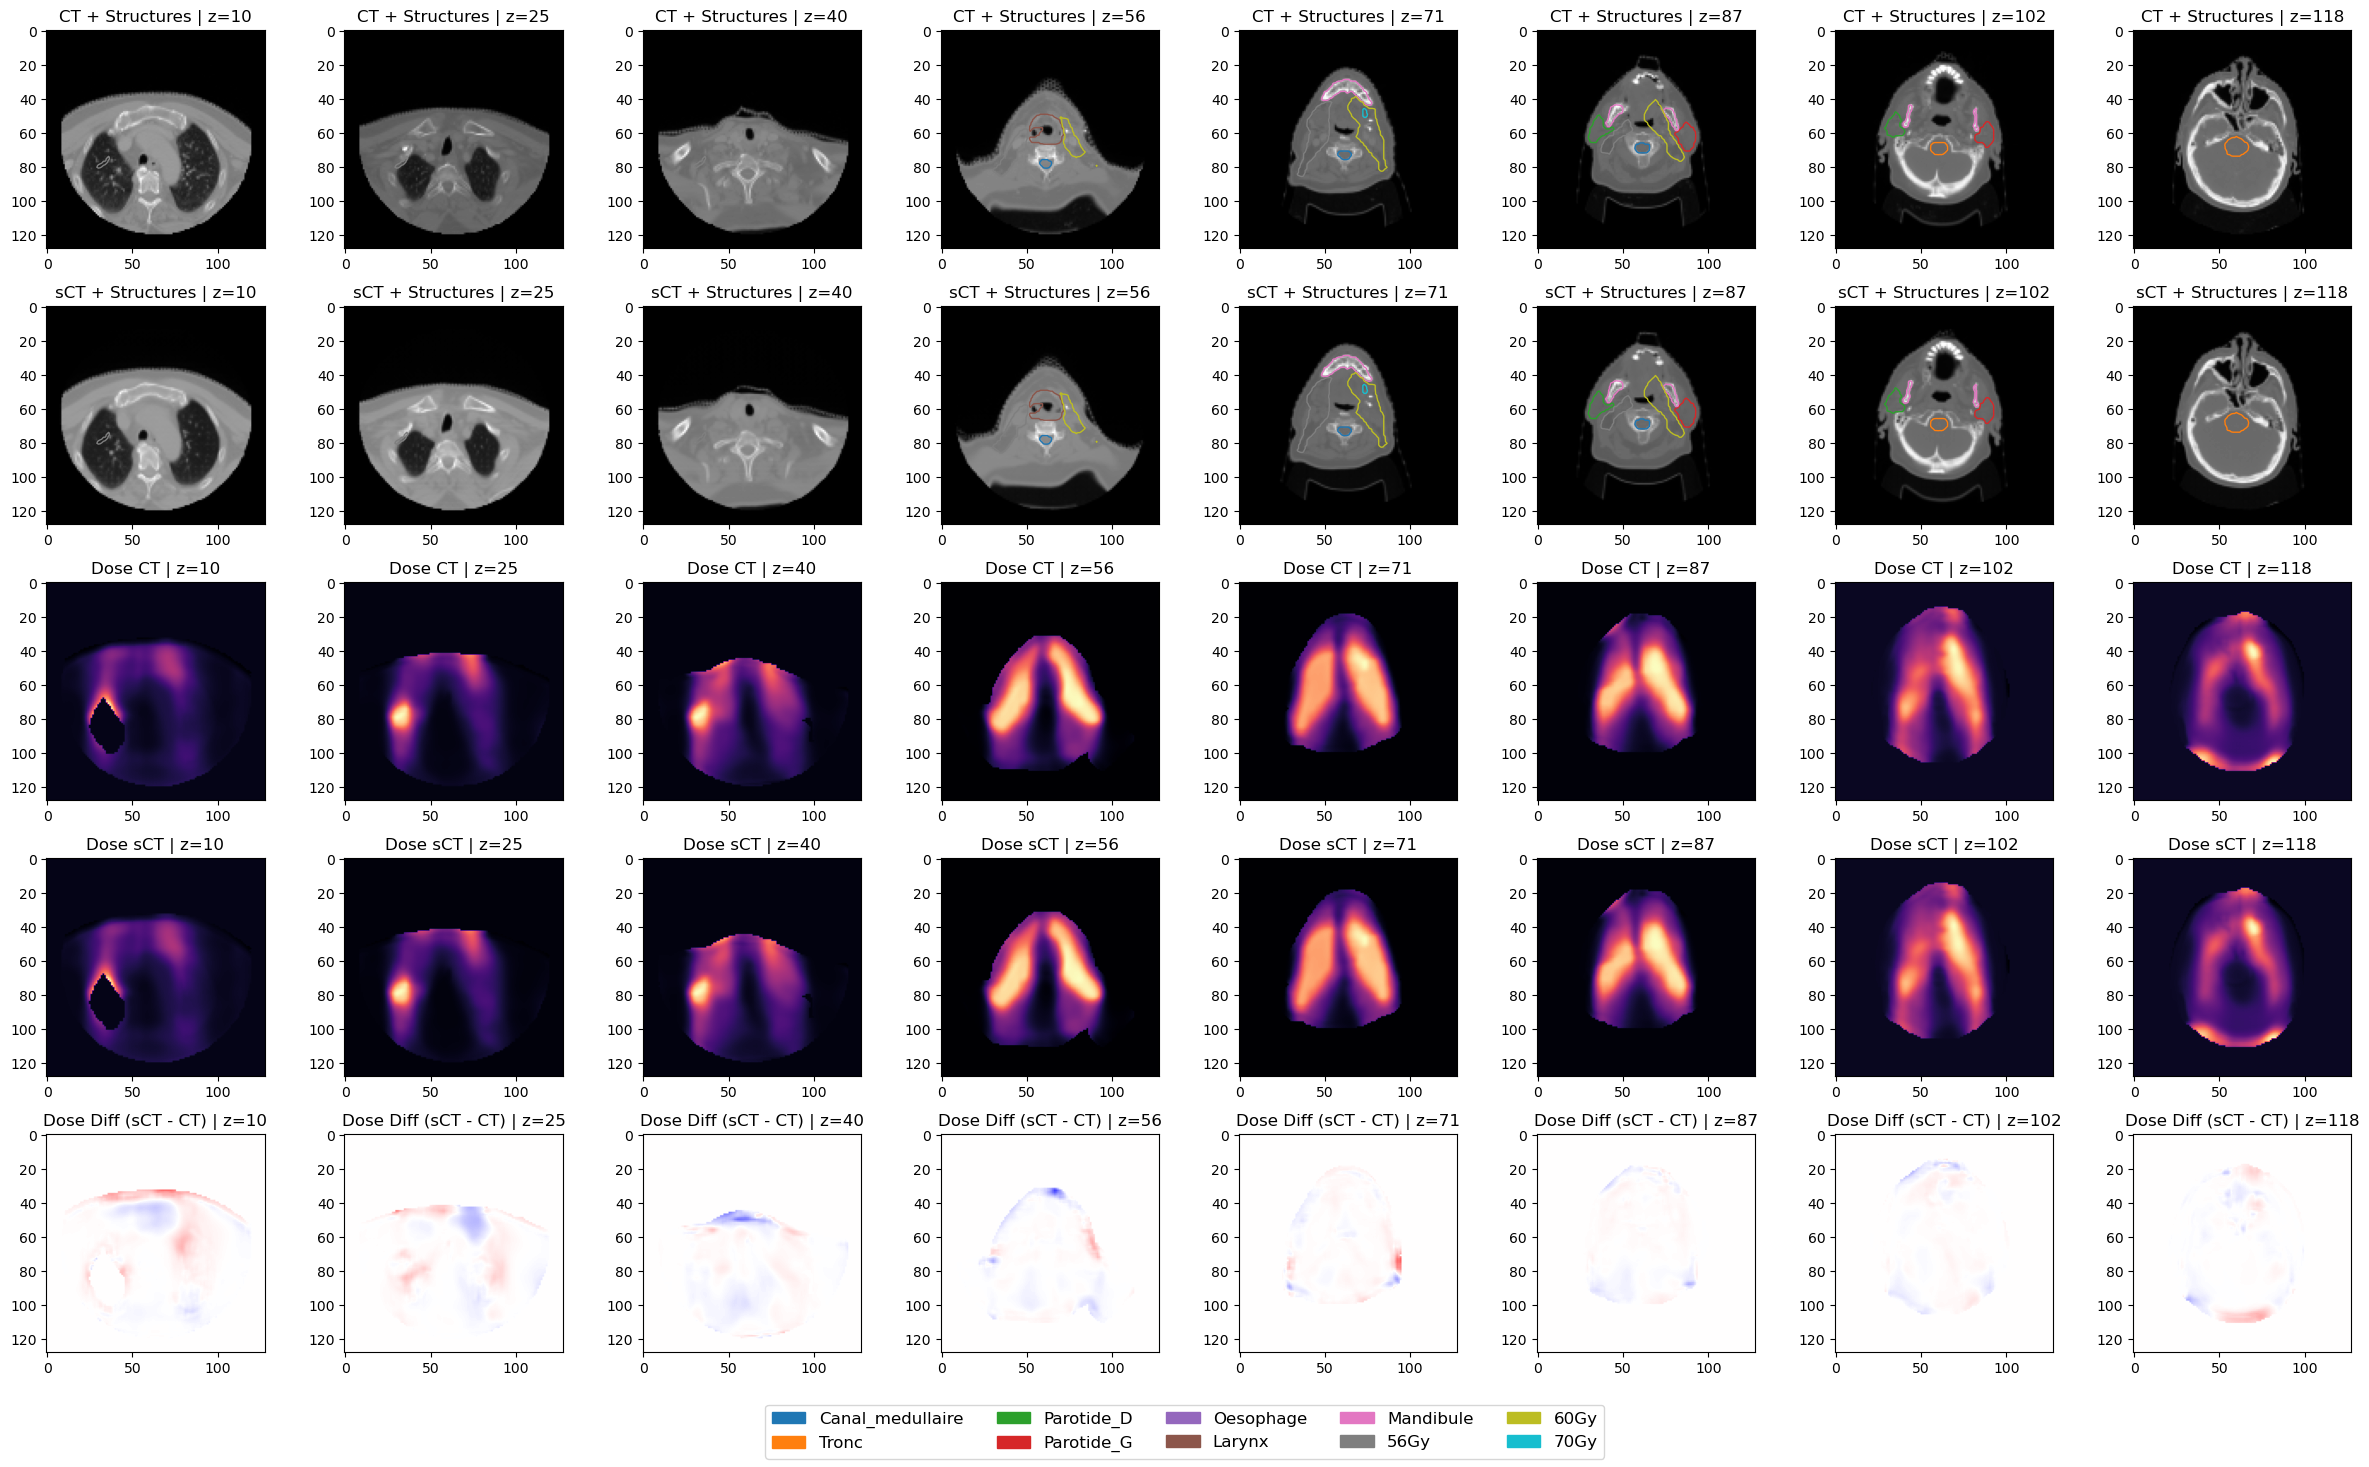

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.patches import Patch

def visualize_dose_prediction(x_out, structure_names, num_slices=10):
    """
    Visualize CT, CBCT, dose predictions and structures.

    Parameters:
        x_out: dict containing 'ct', 'cbct', 'dose_ct', 'dose_cbct', 'structures'
        structure_names: list of names for the 10 structures
        num_slices: number of axial slices to show
    """

    # Extract arrays from tensors
    ct = x_out['ct'][0].cpu().numpy()
    cbct = x_out['sCT'][0].cpu().numpy()
    dose_ct = x_out['dose_ct'][0].cpu().numpy()
    dose_cbct = x_out['dose_sCT'][0].cpu().numpy()
    structures = x_out['structures'].cpu().numpy()  # (10, H, W, D)

    # Compute dose difference
    dose_diff = dose_cbct - dose_ct

    # Color setup
    cmap_structs = plt.get_cmap("tab10")
    struct_colors = [cmap_structs(i % 10) for i in range(len(structure_names))]

    # Choose evenly spaced slices along the axial plane (Z)
    H, W, D = ct.shape
    slice_indices = np.linspace(10, D - 10, num_slices, dtype=int)

    fig, axes = plt.subplots(5, num_slices, figsize=(3 * num_slices, 15))
    if num_slices == 1:
        axes = np.expand_dims(axes, axis=1)

    for i, idx in enumerate(slice_indices):
        # Row 1: CT + contours
        axes[0, i].imshow(ct[idx, :, :], cmap='gray')
        axes[0, i].set_title(f"CT + Structures | z={idx}")
        for j, struct in enumerate(structures):
            if np.any(struct[idx, :, :]):
                axes[0, i].contour(struct[idx, :, :], levels=[0.5], colors=[struct_colors[j]], linewidths=1)

        # Row 2: CBCT + contours
        axes[1, i].imshow(cbct[idx, :, :], cmap='gray')
        axes[1, i].set_title(f"sCT + Structures | z={idx}")
        for j, struct in enumerate(structures):
            if np.any(struct[idx, :, :]):
                axes[1, i].contour(struct[idx, :, :], levels=[0.5], colors=[struct_colors[j]], linewidths=1)

        # Row 3: Dose on CT
        im3 = axes[2, i].imshow(dose_ct[idx, :, :], cmap='magma')
        axes[2, i].set_title(f"Dose CT | z={idx}")
        
        # Row 4: Dose on CBCT
        im4 = axes[3, i].imshow(dose_cbct[idx, :, :], cmap='magma')
        axes[3, i].set_title(f"Dose sCT | z={idx}")

        # Row 5: Dose difference
        im5 = axes[4, i].imshow(dose_diff[idx, :, :], cmap='bwr', vmin=-5, vmax=5)  # in Gy
        axes[4, i].set_title(f"Dose Diff (sCT - CT) | z={idx}")

    # Add colorbar for last row (dose diff)
    # cbar = fig.colorbar(im5, ax=axes[:, -1], shrink=0.6, orientation='vertical', pad=0.01)
    # cbar.set_label("Dose Difference (Gy)", fontsize=14)

    # Add legend for structure colors
    legend_patches = [Patch(color=struct_colors[i], label=structure_names[i]) for i in range(len(structure_names))]
    fig.legend(handles=legend_patches, loc='lower center', ncol=5, fontsize=12)

    plt.tight_layout(rect=[0, 0.05, 1, 0.98])
    plt.show()

structure_names = [
    "Canal_medullaire", "Tronc", "Parotide_D", "Parotide_G",
    "Oesophage", "Larynx", "Mandibule", "56Gy", "60Gy", "70Gy"
]

visualize_dose_prediction(x_out, structure_names, num_slices=8)

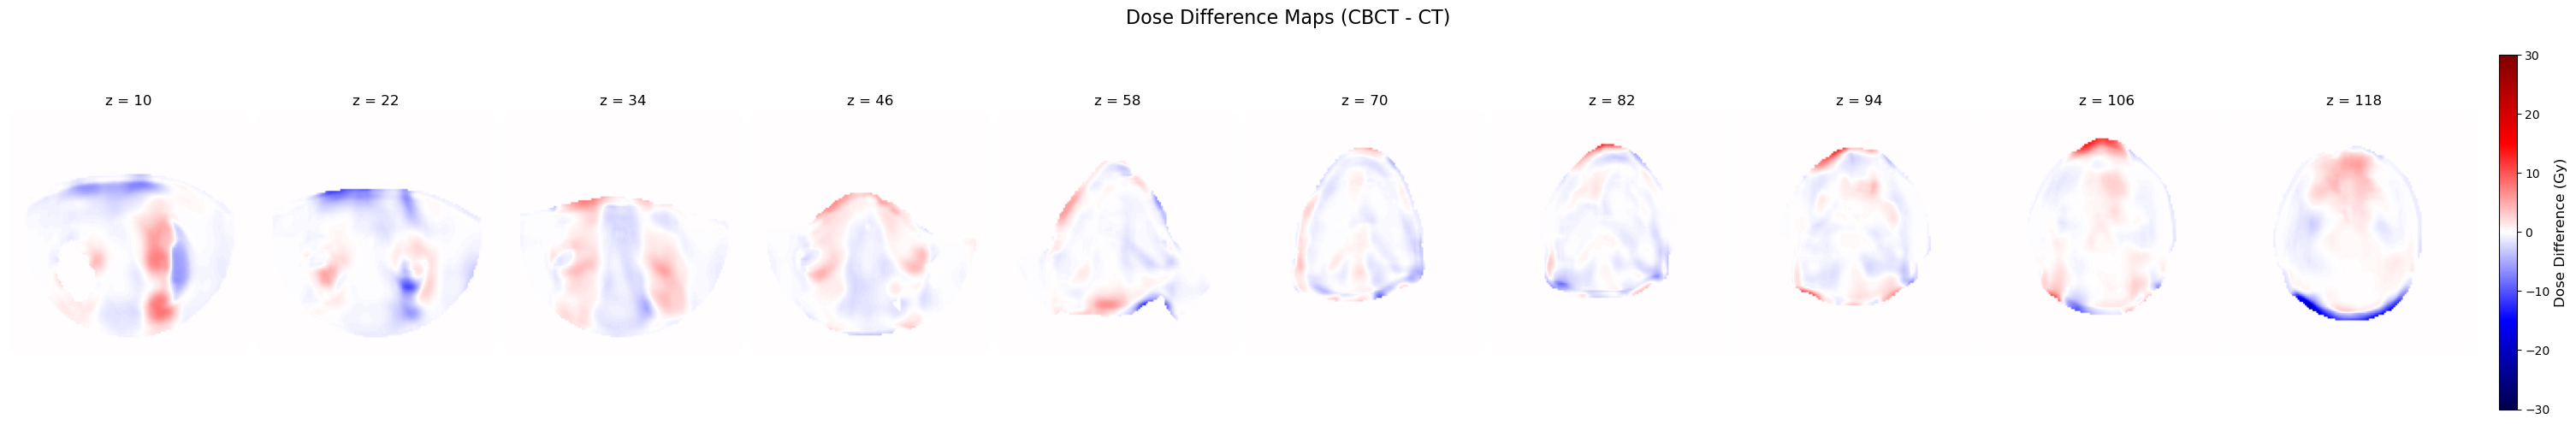

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dose_difference_grid(dose_diff_3d, num_slices=8, vmin=-5, vmax=5, cmap='seismic'):
    """
    Plot multiple axial slices of the dose difference map with one shared colorbar.

    Parameters:
        dose_diff_3d: 3D NumPy array (H, W, D)
        num_slices: Number of axial slices to visualize
        vmin: Minimum value for color scale
        vmax: Maximum value for color scale
        cmap: Colormap for dose difference
    """
    H, W, D = dose_diff_3d.shape
    slice_indices = np.linspace(10, D - 10, num_slices, dtype=int)

    fig, axes = plt.subplots(1, num_slices, figsize=(3 * num_slices, 5), constrained_layout=True)
    if num_slices == 1:
        axes = [axes]

    imgs = []
    for ax, idx in zip(axes, slice_indices):
        im = ax.imshow(dose_diff_3d[idx, :,: ], cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(f"z = {idx}")
        ax.axis('off')
        imgs.append(im)

    # Add single colorbar to the right of the last subplot
    cbar = fig.colorbar(imgs[-1], ax=axes, location='right', shrink=0.9, pad=0.01)
    cbar.set_label("Dose Difference (Gy)", fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    plt.suptitle("Dose Difference Maps (sCT - CT)", fontsize=16)
    plt.show()

dose_diff_np = (x_out['dose_sCT'] - x_out['dose_ct'])[0].cpu().numpy()
plot_dose_difference_grid(dose_diff_np, num_slices=10, vmin=-30, vmax=30)

Compute Mean Dose error and Mean DVH error

In [ ]:
# Extract arrays from tensors
gt = x_out['dose_ct'][0].cpu().numpy()
pred = x_out['dose_cbct'][0].cpu().numpy()
mask = x['possible_dose_mask'] # (1, H, W, D)

In [ ]:
np.sum(np.abs(outCT - outCBCT)) / np.sum(mask)

1.0238068